In [47]:
from Classes import GenData, KnapsackSolver, NeuralNetworkDP
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import time

np.set_printoptions(edgeitems=10,linewidth=180)

In [5]:
n = 100
W = 1000
train_data_num = 3750
test_data_num = 100

normalizer = 4*W

In [6]:
data = GenData(n, W, correlation= 'strong', numObservations=train_data_num)
vw_arr = data.generate()
x_train = np.zeros_like(vw_arr).astype(float)
x_train[:,:,0] = vw_arr[:,:,0]/np.max(vw_arr[:,:,0], axis=1)[:,np.newaxis]
x_train[:,:,1] = vw_arr[:,:,1]/np.max(vw_arr[:,:,1], axis=1)[:,np.newaxis]
y_train = KnapsackSolver().knapsack_DP_Ntable(n, W, vw_arr)
y_train_reshape = np.reshape(y_train, (train_data_num, (n+1)*(W+1)))

In [7]:
y_train_reshape = np.reshape(y_train, (train_data_num, (n+1)*(W+1))).astype(float)

In [8]:
y_train_norm = y_train_reshape/np.max(y_train_reshape, axis=1)[:,np.newaxis]

In [9]:
maxx = np.max(y_train_reshape, axis=1)
maxx = maxx.reshape(1,maxx.shape[0])
maxx_norm = maxx/normalizer
y_train_new = np.concatenate((y_train_norm, maxx_norm.T), axis=1)

In [22]:
#model architecture
model = models.Sequential()

#flatten the input (n, 2) to a single vector
model.add(layers.Flatten(input_shape=(n, 2)))
model.add(layers.Dense(64, activation=tf.keras.layers.LeakyReLU(negative_slope=0.1)))
model.add(layers.Dense(128, activation=tf.keras.layers.LeakyReLU(negative_slope=0.1)))
model.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(negative_slope=0.1)))
model.add(layers.Dense((n + 1) * (W + 1) +1))
model.compile(optimizer='adam', loss='mse')

#model summary to visualize the architecture
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 101102)         │    25,983,214 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,037,422 (99.32 MB)

 Trainable params: 26,037,422 (99.32 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(x_train, y_train_new, batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 357ms/step - loss: 0.0632 - val_loss: 0.0031
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 340ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 332ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 341ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 333ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 339ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 353ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 337ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 349ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 328ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 346ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 12/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 33

In [54]:
n_pred = np.arange(10,1001,30).astype(int)
exec_times = np.zeros_like(n_pred)

for i in range(np.size(n_pred)):
    data_test = GenData(n, W, correlation= 'strong', numObservations=n_pred[i])
    x_test = data_test.generate()
    x_test = x_test.astype(int)
    x_test_norm_pred = np.zeros_like(x_test).astype(float)
    x_test_norm_pred[:,:,0] = x_test[:,:,0]/np.max(x_test[:,:,0], axis=1)[:,np.newaxis]
    x_test_norm_pred[:,:,1] = x_test[:,:,1]/np.max(x_test[:,:,1], axis=1)[:,np.newaxis]

    
    start = time.time()
    pred = model.predict(x_test_norm_pred)
    pred_table = pred[:,:-1]
    pred_val = pred[:,-1]*normalizer
    pred_table_pred = pred_table*pred_val[:,np.newaxis]
    pred_table_pred = pred_table_pred.reshape(n_pred[i],n+1,W+1)
    pred_table_pred = pred_table_pred.astype(int)
    end = time.time()
    exec_times[i] = end - start

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
24/24 ━━━━━━━━━━━━━━

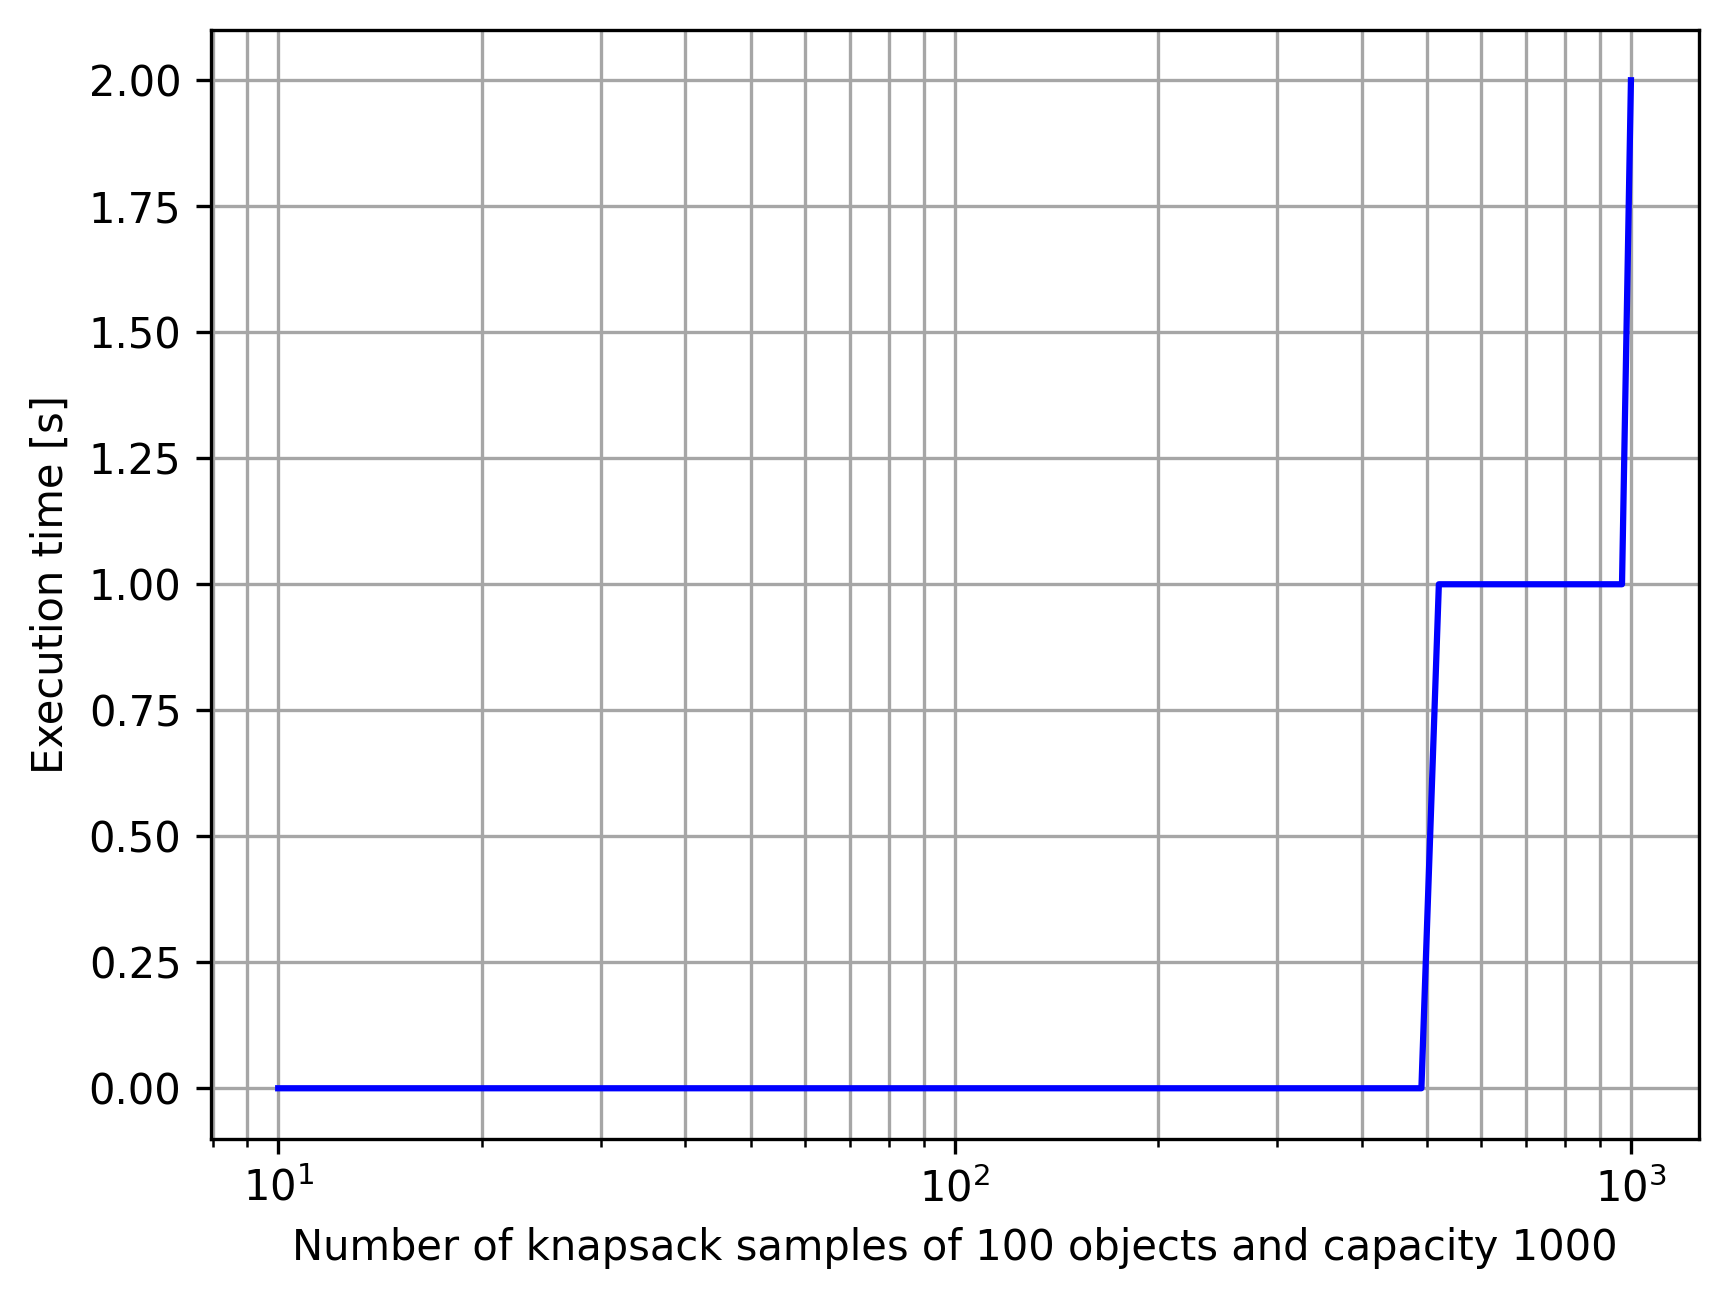

In [56]:
plt.figure(dpi=300)
plt.plot(n_pred, exec_times, color='b')
plt.xscale('log')
plt.ylabel('Execution time [s]')
plt.xlabel('Number of knapsack samples of 100 objects and capacity 1000')
plt.grid(True, which="both", ls="-", color='0.65')
plt.savefig('exec_time_pred.png')
plt.show()

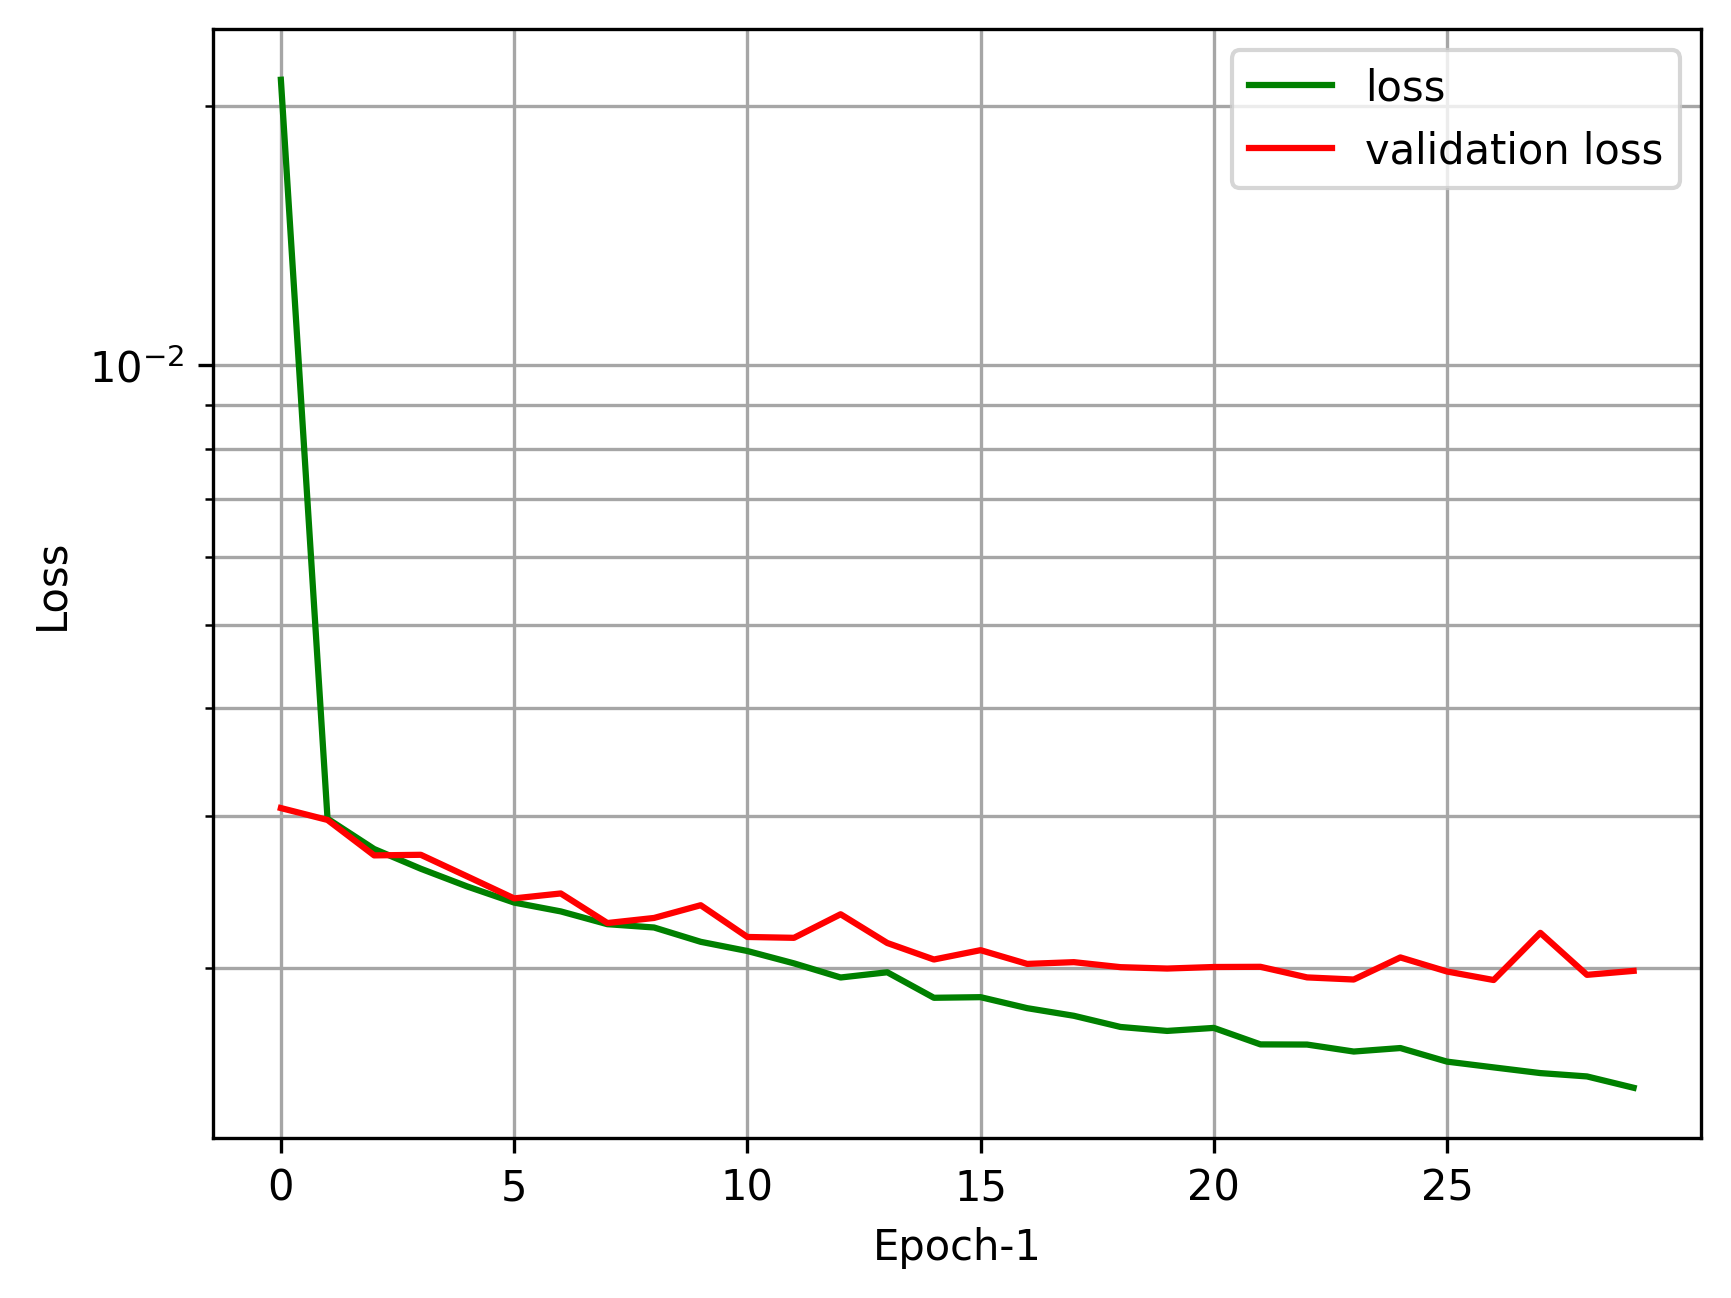

In [41]:
plt.figure(dpi=300)
plt.plot(history.history['loss'], label='loss', color='g')
plt.plot(history.history['val_loss'], label = 'validation loss', color='r')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epoch-1')
plt.grid(True, which="both", ls="-", color='0.65')
plt.xticks(np.arange(0, 30, 5))
plt.legend()
plt.savefig('loss.png')
plt.show()

In [ ]:
init_self = NeuralNetworkDP(n, W, library='self')
model_self = init_self.createModel()

In [ ]:
train_err, val_err, train_acc, val_acc = model_self.fit(vw_arr, y_train_reshape, batch_size=25, epochs=20, validation_split=0.2)

In [ ]:
pred_self = []
for i in range(test_data_num):
    DP_arr = model_self.predict(x_test[i])
    pred_self.append(np.reshape(DP_arr, (2,n+1,W+1)))
    
pred_self = np.array(pred_self)

In [ ]:
opt_val_self = []
idx_self = KnapsackSolver().knapsack_DP_backtrack(pred_self[i], n, W, x_test[i][:,0], x_test[i][:,1])
opt_val_self.append(np.sum(x_test[i][idx_self,0]))

In [10]:
y_train_reshape.shape

(2500, 101101)

In [17]:
a = np.arange(1,11).reshape(2,5)

In [18]:
b = np.array([2,3])

In [19]:
a*b[:,np.newaxis]

array([[ 2,  4,  6,  8, 10],
       [18, 21, 24, 27, 30]])

In [24]:
vw_arr[:][

array([ 241,  666,  171,  815, 1067,  193,  497,  588,  891, 1036,  999,  165,  702,  502,  797,  512, 1076,  985,  253,  976,  285,  424,  733,  936,  224,  299,  784,  720,
        791,  877, 1022,  266,  361, 1066, 1092,  742,  690,  112,  936,  344,  273,  542,  622,  979,  865, 1018,  208,  695,  234,  503,  872,  800,  280,  882,  429,  826,
        615,  423,  150, 1075,  232,  106,  159,  893,  229,  189,  533,  681,  530,  426,  307,  638,  320,  528,  412,  308,  922,  466,  427,  409,  835,  893,  182,  855,
        837, 1075,  579,  229,  532,  869, 1038,  473,  577,  465,  712,  331,  498,  637,  572,  724])

In [31]:
a = np.max(vw_arr[:][:,0])

In [61]:
a = vw_arr[:,:,0]/np.max(vw_arr[:,:,0], axis=1)[:,np.newaxis]

In [64]:
a[0]*1092

array([ 241.,  666.,  171.,  815., 1067.,  193.,  497.,  588.,  891., 1036.,  999.,  165.,  702.,  502.,  797.,  512., 1076.,  985.,  253.,  976.,  285.,  424.,  733.,  936.,
        224.,  299.,  784.,  720.,  791.,  877., 1022.,  266.,  361., 1066., 1092.,  742.,  690.,  112.,  936.,  344.,  273.,  542.,  622.,  979.,  865., 1018.,  208.,  695.,
        234.,  503.,  872.,  800.,  280.,  882.,  429.,  826.,  615.,  423.,  150., 1075.,  232.,  106.,  159.,  893.,  229.,  189.,  533.,  681.,  530.,  426.,  307.,  638.,
        320.,  528.,  412.,  308.,  922.,  466.,  427.,  409.,  835.,  893.,  182.,  855.,  837., 1075.,  579.,  229.,  532.,  869., 1038.,  473.,  577.,  465.,  712.,  331.,
        498.,  637.,  572.,  724.])

In [57]:
np.max(vw_arr[:,:,0], axis=1)

array([1092, 1093, 1099, 1098, 1089, 1093, 1095, 1091, 1096, 1097, ..., 1091, 1095, 1097, 1100, 1100, 1097, 1095, 1100, 1100, 1081])

In [54]:
vw_arr[:,:,0]

array([[ 241,  666,  171,  815, 1067,  193,  497,  588,  891, 1036, ..., 1038,  473,  577,  465,  712,  331,  498,  637,  572,  724],
       [ 553,  957,  486,  624,  135,  818, 1047, 1009,  979,  241, ...,  953,  572,  315,  235,  947,  146,  345,  317,  504,  521],
       [ 989,  256,  404,  138,  220, 1001,  631,  105,  121,  143, ..., 1000,  770,  447,  176,  865,  902, 1018,  174, 1045,  184],
       [ 595,  618,  644,  200,  738,  864, 1059,  208,  832,  290, ...,  278,  126,  996,  121, 1024,  319,  715,  371,  889,  290],
       [ 972,  639,  650,  308,  614,  950, 1016,  984,  220,  849, ...,  776,  797,  953,  299, 1018,  371,  326,  398,  559,  856],
       [ 512, 1080,  641,  338,  981,  178,  691,  287,  486,  713, ...,  937,  537,  281, 1003, 1091, 1006,  686,  500,  960,  546],
       [ 410,  523,  941,  980,  895,  240, 1095, 1036,  191,  204, ..., 1038,  241,  766,  493,  859,  883,  612,  317,  954,  837],
       [ 741,  425,  171,  324,  834,  615,  946,  792,  848, 

In [58]:
data_test = GenData(n, W, correlation= 'strong', numObservations=test_data_num)
x_test = data_test.generate()
x_test = x_test.astype(int)
x_test_norm = np.zeros_like(x_test).astype(float)
x_test_norm[:,:,0] = x_test[:,:,0]/np.max(x_test[:,:,0], axis=1)[:,np.newaxis]
x_test_norm[:,:,1] = x_test[:,:,1]/np.max(x_test[:,:,1], axis=1)[:,np.newaxis]
y_test = KnapsackSolver().knapsack_DP_Ntable(n, W, x_test).astype(int)

pred = model.predict(x_test_norm)
pred_table = pred[:,:-1]
pred_val = pred[:,-1]*normalizer
pred_table_pred = pred_table*pred_val[:,np.newaxis]
pred_table_pred = pred_table_pred.reshape(test_data_num,n+1,W+1)
pred_table_pred = pred_table_pred.astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [74]:
print(np.mean(np.absolute(y_test-pred_table_pred)))

120.08719923640716


In [70]:
print(np.mean(np.absolute(y_test[:,-1,-1]-pred_table_pred[:,-1,-1])))

203.41
